# Data Labeling


The goal is to see how the data labeling process affects the performance of a classification model.

The iguanas images below show valid labeling alternatives but they clearly follow different criteria. 

<table><tr><td><img src='assets/iguanas1.png'></td><td><img src='assets/iguanas2.png'></td><td><img src='assets/iguanas3.png'></td></tr></table>

If data is labelled using different creteria, it might impact negatively on the learning algorithm. It is desired to have consistent labeling across your dataset.

**The main objective of this exercise is to compare performance across labeling options to understand the role that good labeling plays on the performance of Machine Learning models**, these options are:
1. Randomly generated labels (performance lower bound)
2. Automatic generated labels based on three different label strategies
3. True labels (performance upper bound)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

The dataset consists of 5 CSV files, one for each video. Pandas `DataFrame` are very powerful to handle data in CSV format. The following helper function will load the data using pandas:

In [3]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""

    # Path where csv files are located
    base_path = "./data/"

    # List of csv files with full path
    csv_files = [os.path.join(base_path, csv) for csv in os.listdir(base_path)]

    # List of dataframes for each file
    dfs = [pd.read_csv(filename) for filename in csv_files]

    # Concatenate dataframes into a single one
    df = pd.concat(dfs)

    # Rename columns
    df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

    # Set a seed for the order of rows
    df = df.sample(frac=1, random_state=824)
    
    return df.reset_index()


# Save the dataframe into the df_labeled variable
df_labeled = load_labeled_spam_dataset()

Let's check the top 5 rows of the data:

In [4]:
# Take a look at the first 5 rows
df_labeled.head()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,86,z12uzb3oxy23cbikz23qsjczaxz5wh1t5,luisel Tutoriales Gameplays (luisel Tutoriales),2015-05-23T18:56:07.484000,music yeah﻿,0
1,291,z122z5pa2wyofbjj304cgfwrrmvjgn0pohc,Mia Aspinall,2014-11-08T10:30:35,"2 billion views, only 2 million shares﻿",0
2,142,z13bttm5gxecfvrqq04cevkpuxj5s1u5ys40k,Vane Cavazos,2014-09-20T15:39:44,Katycat! https://m.facebook.com/profile.php?id...,1
3,147,z132zl1rupqcylbep23jgfig3um3ct5vv,KatyPerry TheQueenOfPop,2014-09-22T06:50:24,--&gt;ATTENTION KATYCATS! Katy leads with 7 no...,1
4,326,z12usr54ppaxxf1dl23nhbybruapdnixw04,Arthur Teixeira,2014-11-12T20:12:47,I wanted to know the name of the guy that danc...,0


## Preprocessing


### Checking for data imbalance

It is fairly common to assume that the data we have is balanced. This means that the dataset contains a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class:

1    1005
0     951
Name: label, dtype: int64



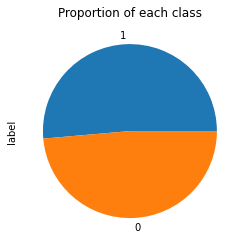

In [5]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

There is roughly the same number of data points for each class so class imbalance is not an issue for this particular dataset.


### Cleaning the dataset

Let's drop the unneccesary columns.

In [6]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label
0,music yeah﻿,0
1,"2 billion views, only 2 million shares﻿",0
2,Katycat! https://m.facebook.com/profile.php?id...,1
3,--&gt;ATTENTION KATYCATS! Katy leads with 7 no...,1
4,I wanted to know the name of the guy that danc...,0


### Splitting the dataset

Splitting data to training and test sets. We use 
stratification so the proportion of classes is maintained within each split.

In [7]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


visual to check that the stratification:

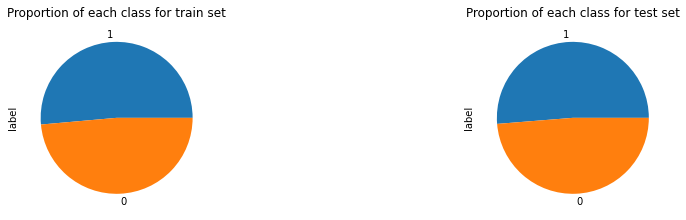

In [8]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

## Data Labeling 

Establishing performance lower and upper bounds for reference



### Calculate accuracy of a labeling strategy

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in the sklearn ecosystem to encode text based data.



In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

Now that the text encoding is defined, we select a model to make predictions. For simplicity you will use a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. This model is well suited for text classification and is fairly quick to train.

Below is a function that will handle the model fitting and print out the accuracy on the test data:

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)


dictionary  to store the accuracy of each labeling method:

In [12]:
# dictionary
accs = dict()

### Random Labeling

Generating random labels is a natural way to establish a lower bound. 

let's check on the accuracy for the random labeling method

In [13]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.5663265306122449

To further gain intuition let's look at the average accuracy over 10 runs:

In [14]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 48.44%


### Labeling with true values

Retrain the Multinomial Naive Bayes classifier with the actual labels 

In [15]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 91.58%


## Automatic labeling - Trying out different labeling strategies

We'll use a spam email dataset.

How we will encode the labeling:
- `SPAM` is represented by 1


- `NOT_SPAM` by 0 


- `NO_LABEL` as -1


### First iteration - Define some rules

For this first iteration create three rules based on the intuition of common patterns that appear on spam comments. The rules are simple, classify as SPAM if any of the following patterns is present within the comment or NO_LABEL otherwise:
- `free` - spam comments usually lure users by promoting free stuff
- `subs` - spam comments tend to ask users to subscribe to some website or channel
- `http` - spam comments include links very frequently

In [16]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If the comment falls under any of the rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [17]:
# Apply the rules the comments in the train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at the automatic labels
labels

array([-1, -1, -1, ..., -1, -1,  1])

For lots of points the automatic labeling algorithm decided to not settle for a label, this is expected given the nature of the rules that were defined. These points should be deleted since they don't provide information about the classification process and tend to hurt performance.

In [18]:
# Create the automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (379,)
Proportion of data points kept: 24.23%


Notice that only 379 data points remained out of the original 1564. The rules defined didn't provide enough context for the labeling algorithm to settle on a label, so around 75% of the data has been trimmed.

Test the accuracy of the model when using these automatic generated labels:

In [19]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save the result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 51.28%


Comparing this accuracy to the baselines by plotting:

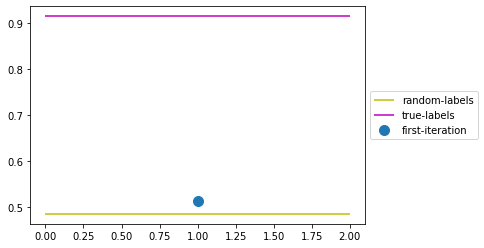

In [20]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy very close to the random labeling, we'll try to do better than this. 

In [21]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to the comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

To Note: we should come up with rules that have a better coverage of the training data, thus making pattern discovery easier. Also notice how the rules were only able to label as either SPAM or NO_LABEL, we should also create some rules that help the identification of NOT_SPAM comments.

### Second iteration - Coming up with better rules

Check out common patterns in data, i.e not spam comments often make references to either the number of views since these were the most watched videos of 2015 or the song in the video and its contents . As for spam comments other common patterns are to promote gifts or ask to follow some channel or website.

We'll create some new rules that include these patterns:

In [22]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

The new set of rules looks more promising, it includes more patterns to classify as SPAM as well as some patterns to classify as NOT_SPAM. This should result in more data points with a label different to NO_LABEL.


Proportion of data points kept: 44.12%

second-iteration labeling has an accuracy of 70.92%



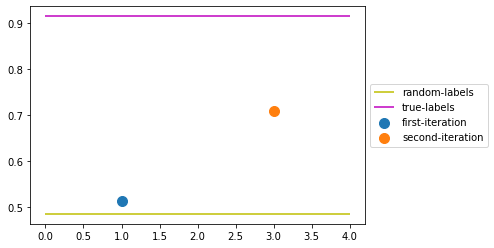

In [23]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

This time 44% of the original dataset was given a decisive label and there were data points for both labels, this helped the model reach a higher accuracy when compared to the first iteration. Now the accuracy is considerably higher than the random labeling but it is still very far away from the upper bound.


### Third Iteration - Even more rules

The rules we have so far are doing a fair job. We'll add two additional rules, one for classifying SPAM comments and the other for the opposite task.

At a glimpse it looks like NOT_SPAM comments are usually shorter. This may be due to them not including hyperlinks but also in general they tend to be more concrete such as "I love this song!".

Let's take a look at the average number of characters for SPAM comments vs NOT_SPAM oned:

In [24]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 49.64 characters.
SPAM comments have an average of 137.34 characters.


There is a big difference in the number of characters for both types of comments.

To decide on a threshold to classify as NOT_SPAM let's plot a histogram of the number of characters for NOT_SPAM comments:

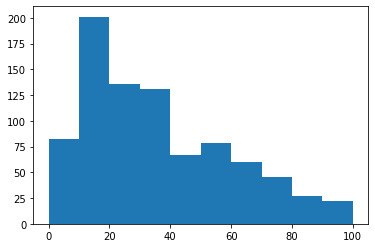

In [25]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

The majority of NOT_SPAM comments have 30 or less characters so we'll use that as a threshold.

Another prevalent pattern in spam comments is to ask users to "check out" a channel, website or link.

Let's add these two new rules:

In [26]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 78.26%

third-iteration labeling has an accuracy of 86.22%



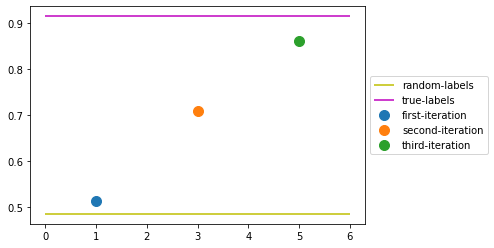

In [27]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()